This notebook shows which user traits make each demographic group more or less likely. It uses the linear model built in the [parent script](https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/a-linear-model-on-apps-and-labels). What can the coefficients of logistic regression tell us about demographic groups?

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data

In [2]:
datadir = '../input'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))
labelcats = pd.read_csv(os.path.join(datadir,'label_categories.csv'),
                        index_col='label_id',squeeze=True)

## Feature Engineering

In [3]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [4]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [5]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [6]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())

In [7]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [8]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [9]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())

In [10]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [11]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


## Build model

In [12]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [13]:
clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Look at coefficients

Logistic regression has a matrix of coefficients of shape (n_classes, n_features). Since all our features are on the same scale we can directly compare coefficients values. Positive coefficients mean that this feature makes this class more likely, negative - less likely.

In [14]:
coef = clf.coef_
coef.shape

(12, 21527)

In [15]:
# convert feature index to feature name
def map_feature(n):
    m = n+0
    if m < len(brandencoder.classes_):
        return 'brand {}'.format(brandencoder.classes_[m])
    m -= len(brandencoder.classes_)
    if m < len(modelencoder.classes_):
        return 'model {}'.format(modelencoder.classes_[m])
    m -= len(modelencoder.classes_)
    if m < len(appencoder.classes_):
        return 'app {}'.format(appencoder.classes_[m])
    m -= len(appencoder.classes_)
    return 'label {}'.format(labelcats.loc[labelencoder.classes_[m]])

Here is a plot of 10 largest positive (red) and negative (blue) coefficients for each gender-age group.

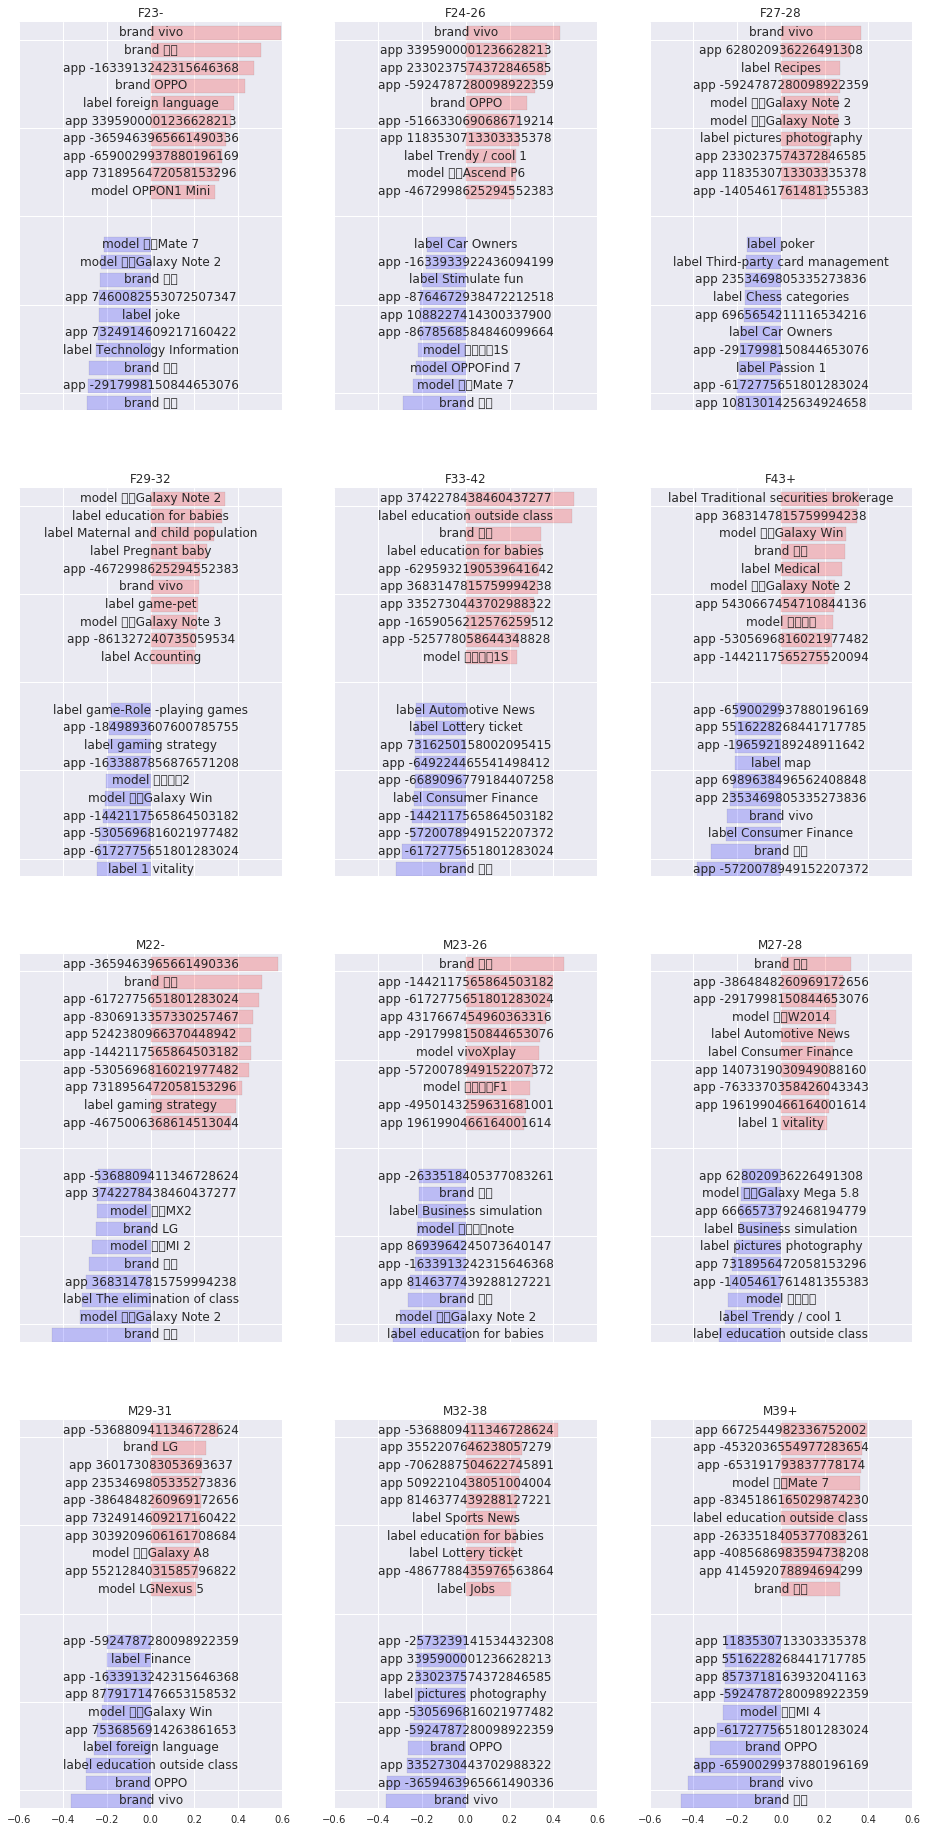

In [16]:
N = 10 # Number of positive and negative traits to plot
fig, ax = plt.subplots(4,3, figsize=(16,32), sharex=True)
ax = ax.flatten()
for i in range(12):
    ax[i].set_title(targetencoder.classes_[i])
    ind = np.argsort(coef[i,:])
    for n in range(N):
        ax[i].barh([-(N-n)-1], [coef[i,ind[n]]], color='b',alpha=0.2)
        ax[i].text(0, -(N-n)-0.6, map_feature(ind[n]),
                   horizontalalignment='center',
                   verticalalignment = 'center')
        ax[i].barh([N-n], [coef[i,ind[-n-1]]], color='r',alpha=0.2)
        ax[i].text(0, N-n+0.4, map_feature(ind[-n-1]),
                   horizontalalignment='center',
                   verticalalignment = 'center')
        ax[i].set_ylim(-N-1,N+1)
    ax[i].set_yticklabels([''])